# Prediction with C3D feature

In [1]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import preprocessing
import sys
import os

# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

Using TensorFlow backend.


In [27]:
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # conversion to float type
    return C3D
def vname2ID(vnames):
    """Parse video digital id from its name
    vnames: a list contains file names"""
    vid = [ os.path.splitext(vn)[0]+'.webm' for vn in vnames]
    return vid
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

## Feature load and Split

In [30]:
# loading the data in dataframe
label_path = 'H:/DCU Study/ML/import/dev-set_ground-truth.csv'
labels=pd.read_csv(label_path)

In [31]:
# Display df head
labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [5]:
#Some statistics for this dataset
labels.describe()

,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.860243,36.291500,0.778942,12.764667
std,0.080655,8.356285,0.144692,3.544815
min,0.388000,30.000000,0.000000,9.000000
25%,0.811000,33.000000,0.700000,10.000000
50%,0.867000,34.000000,0.800000,12.000000
75%,0.923000,34.000000,0.900000,14.000000
max,0.989000,100.000000,1.000000,40.000000


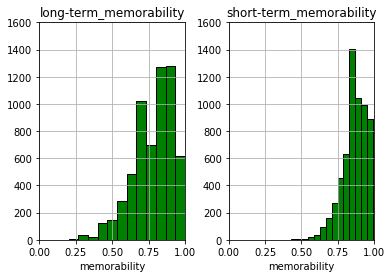

In [40]:
# histogram of labels
bins = 15
figs = labels[['short-term_memorability', 'long-term_memorability']].hist(bins=bins,color = 'green',edgecolor = 'black')

for fig in figs[0]:
  fig.set_xlabel('memorability')
  fig.set_ylim(0, 1600)
  fig.set_xlim(0, 1)
  fig.set_xlabel('memorability')
  fig.set_ylim(0, 1600)
  fig.set_xlim(0, 1)

In [43]:
# Load dev-set feature
Feature_path = 'H:/DCU Study/ML/dev-set/dev-set_features/'
vid = labels.video.values

Features = pd.DataFrame({'video': vid,'C3D': [read_C3D(Feature_path+'C3D'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],})


In [42]:
# Display dev-set feature head
Features.head()

,video,C3D
0,video3.webm,"[0.02024942, 0.0015778, 0.00082625, 0.00094509..."
1,video4.webm,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ..."
2,video6.webm,"[0.01176522, 0.00074577, 0.00078353, 1.328e-05..."
3,video8.webm,"[0.00022343, 0.00016499, 7.35e-06, 1.615e-05, ..."
4,video10.webm,"[9.006e-05, 0.00061494, 0.00343634, 0.00128092..."


In [44]:
# Spliting into train/test
X = np.stack(Features['C3D'].values)
Y = labels[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

In [45]:
# Print values
print('X_train', X_train.shape)
print('X_val', X_val.shape)
print('Y_train', Y_train.shape)
print('Y_val', Y_val.shape)

X_train (4800, 101)
X_val (1200, 101)
Y_train (4800, 2)
Y_val (1200, 2)


In [46]:
# Load testing data
test_path = 'H:/DCU Study/ML/test-set/'
test_vid = os.listdir(test_path+'C3D')
Features_test = pd.DataFrame({'video': test_vid,'C3D': [read_C3D(test_path+'C3D'+'/'+item) for item in test_vid], })
X_test = np.stack(Features_test['C3D'].values)

# Define metrics

In [47]:
import keras.backend as K
K.set_floatx('float64')
import tensorflow as tf
import tensorflow.contrib.metrics as M
def spearmann_rank_coeff(y_true, y_pred):
    '''Spearmann rank correlation coefficient is'''
    y_true_rank = y_true
    y_pred_rank = y_pred
    y_t_mean = tf.reduce_mean(y_true_rank,0)
    y_p_mean = tf.reduce_mean(y_pred_rank,0)
    x = tf.subtract(y_pred_rank,y_p_mean)
    y =tf.subtract(y_true_rank,y_t_mean)
    xcov = 1/tf.shape(x)[0] * tf.reduce_sum(x * y)
    coef = tf.divide(xcov,K.std(y_true_rank)*K.std(y_pred_rank))
    return coef

def test_coeff(y_true,y_pred):
    return M.streaming_(y_true,y_pred)

In [13]:
a=tf.constant([[3.1,4.5,2,7],[1,2,3,4]],dtype=tf.float64)
b=tf.constant([[3.5,6,2.9,9],[5,4,3,2]],dtype=tf.float64)
res=spearmann_rank_coeff(a,b)

In [14]:
with tf.Session() as sess:
    sess.run(res)
    print(res.eval())

1.5698467415620858


# Model Building and Training

In [49]:
model = Sequential()
model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(200,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               20400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 402       
Total params: 61,002
Trainable params: 61,002
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc',spearmann_rank_coeff])
history=model.fit(x=X_train,y=Y_train,batch_size=80,epochs=50,validation_split=0.2,shuffle=True,verbose=True)

Train on 3840 samples, validate on 960 samples
Epoch 1/50
3840/3840 [==============================] - 0s 112us/step - loss: 0.1104 - acc: 0.7073 - spearmann_rank_coeff: 0.0818 - val_loss: 0.0865 - val_acc: 0.6813 - val_spearmann_rank_coeff: 0.1504
Epoch 2/50
3840/3840 [==============================] - 0s 48us/step - loss: 0.0886 - acc: 0.7091 - spearmann_rank_coeff: 0.1790 - val_loss: 0.0867 - val_acc: 0.6813 - val_spearmann_rank_coeff: 0.1517
Epoch 3/50
3840/3840 [==============================] - 0s 38us/step - loss: 0.0871 - acc: 0.7091 - spearmann_rank_coeff: 0.2166 - val_loss: 0.0869 - val_acc: 0.6813 - val_spearmann_rank_coeff: 0.1360
Epoch 4/50
3840/3840 [==============================] - 0s 40us/step - loss: 0.0868 - acc: 0.7091 - spearmann_rank_coeff: 0.2339 - val_loss: 0.0868 - val_acc: 0.6813 - val_spearmann_rank_coeff: 0.1837
Epoch 5/50
3840/3840 [==============================] - 0s 44us/step - loss: 0.0868 - acc: 0.7083 - spearmann_rank_coeff: 0.2358 - val_loss: 0.0870 

3840/3840 [==============================] - 0s 50us/step - loss: 0.0809 - acc: 0.7091 - spearmann_rank_coeff: 0.4855 - val_loss: 0.0896 - val_acc: 0.6823 - val_spearmann_rank_coeff: 0.1440
Epoch 42/50
3840/3840 [==============================] - 0s 43us/step - loss: 0.0808 - acc: 0.7117 - spearmann_rank_coeff: 0.4842 - val_loss: 0.0895 - val_acc: 0.6802 - val_spearmann_rank_coeff: 0.1305
Epoch 43/50
3840/3840 [==============================] - 0s 35us/step - loss: 0.0805 - acc: 0.7146 - spearmann_rank_coeff: 0.4994 - val_loss: 0.0892 - val_acc: 0.6802 - val_spearmann_rank_coeff: 0.1503
Epoch 44/50
3840/3840 [==============================] - 0s 35us/step - loss: 0.0804 - acc: 0.7138 - spearmann_rank_coeff: 0.5010 - val_loss: 0.0892 - val_acc: 0.6729 - val_spearmann_rank_coeff: 0.1968
Epoch 45/50
3840/3840 [==============================] - 0s 36us/step - loss: 0.0806 - acc: 0.7159 - spearmann_rank_coeff: 0.5089 - val_loss: 0.0890 - val_acc: 0.6771 - val_spearmann_rank_coeff: 0.1602
Ep

# Visualizing

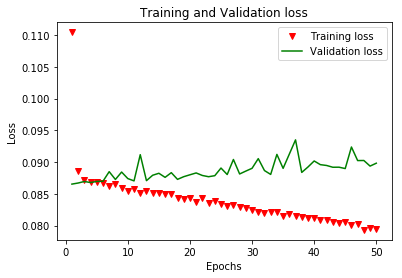

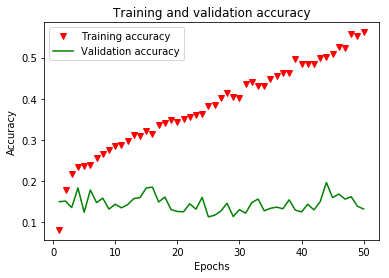

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'rv',label='Training loss')
plt.plot(epochs,val_loss,'g',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['spearmann_rank_coeff']
val_acc = history.history['val_spearmann_rank_coeff']
plt.plot(epochs, acc, 'rv', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


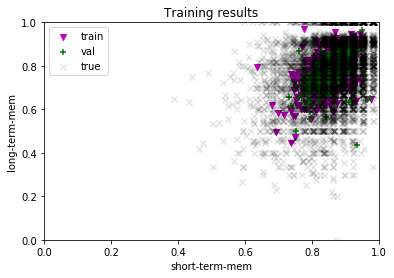

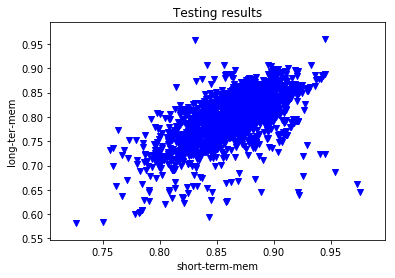

In [54]:
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)

if len(Y.shape) == 2:
    plt.figure()
    plt.scatter(Y_pred_train[:,0],Y_pred_train[:,1],marker='v',c='m',label='train')
    plt.scatter(Y_pred_val[:,0],Y_pred_val[:,1],marker='+',c='g',label='val')
    plt.scatter(Y[:,0],Y[:,1],marker='x',c='k',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('short-term-mem')
    plt.ylabel('long-term-mem')
    plt.title('Training results')
    plt.show()
    
    # plot testing results
    Y_pred = model.predict(X_test[:,:],batch_size=32)
    plt.figure()
    plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='v',c='b')
    plt.xlabel('short-term-mem')
    plt.ylabel('long-ter-mem')
    plt.title('Testing results')
    plt.show()
    
else:
    plt.figure()
    plt.scatter(Y_pred_train,Y_train,marker='b',c='b',label='train')
    plt.scatter(Y_pred_val,Y_val,marker='x',c='y',label='val')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.title('Training results [short-term]')
    plt.show()

In [55]:
Res = pd.DataFrame

In [56]:
Y_pred = model.predict(X_val)

In [57]:
Res_short = pd.DataFrame({'Y_true':Y_val[:,0],'Y_pred':np.squeeze(Y_pred[:,0])})

In [58]:
spearman_rank_correlation_coefficient = Res_short[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
score_short = round(spearman_rank_correlation_coefficient.iloc[1][0],3)
print('Short-Term Spearman\'s correlation is : %.3f' % score_short)

Short-Term Spearman's correlation is : 0.256


In [59]:
Res_long = pd.DataFrame({'Y_true':Y_val[:,1],'Y_pred':np.squeeze(Y_pred[:,1])})
spearman_rank_correlation_coefficient_long = Res_long[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
score_long = round(spearman_rank_correlation_coefficient_long.iloc[1][0],3)
print('Long-Term Spearman\'s correlation is : %.3f' % score_long)

Long-Term Spearman's correlation is : 0.099


In [60]:
Get_score(Y_pred,Y_val)


The Spearman's correlation coefficient is: 0.256
The Spearman's correlation coefficient is: 0.099


In [61]:
df=(Y_pred,Y_val)

In [26]:
# Printing all values
np.set_printoptions(threshold=sys.maxsize)
print(df)


(array([[0.88176993, 0.88535039],
       [0.83078554, 0.64808916],
       [0.85576483, 0.77352311],
       [0.87040026, 0.76914668],
       [0.85132208, 0.84030738],
       [0.87518725, 0.81981552],
       [0.81208357, 0.71117578],
       [0.88668655, 0.87238191],
       [0.82991919, 0.74172916],
       [0.82266099, 0.81720808],
       [0.81183051, 0.74307789],
       [0.88871279, 0.80328318],
       [0.89303033, 0.82251033],
       [0.89328459, 0.81272676],
       [0.91513083, 0.87883255],
       [0.87725471, 0.82200253],
       [0.87508707, 0.81013796],
       [0.87842029, 0.80514992],
       [0.87753318, 0.77578301],
       [0.88079385, 0.78961089],
       [0.89924709, 0.78866509],
       [0.87029983, 0.85090514],
       [0.89280652, 0.80464074],
       [0.81109604, 0.74982062],
       [0.88220865, 0.73253255],
       [0.87521258, 0.76210947],
       [0.90434412, 0.85801546],
       [0.89621383, 0.8221571 ],
       [0.89956342, 0.81097993],
       [0.88482171, 0.78969282],
       [0